# Vulnerability and fragility curves for GMMA

Introduction for calculating damage and or damage states.

Start by using the matplotlib magic to allow us to display plots inline.

In [1]:
%matplotlib inline

Now import the required modules to allow plotting, loading data, generating the curves and interacting with them.

In [2]:
import numpy as np
from scipy.stats import lognorm

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

import seaborn; seaborn.set()

# Import widgets for interactive notebook
from IPython.html.widgets import interact, fixed, interactive
from IPython.html import widgets
from IPython.display import display

from StringIO import StringIO

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [41]:
fragilitycurves = StringIO("""Type,Mean,SD,Scale,Slight,SD,Scale,Moderate,SD,Scale,Extensive,SD,Scale,Complete,SD,Scale
C1-L-S,477.26,0.46,1.00000,209,0.23,1.00000,241,0.2,1.00000,277,0.17,1.00000,371,0.13,1.00000
C1-L-W,416.41,0.52,1.00000,132,0.17,1.00000,208,0.16,1.00000,240,0.14,1.00000,301,0.17,1.00000
C1-M,221.00,0.33,0.13333,144,0.17,0.133333,171,0.17,0.133333,218,0.22,0.133333,270,0.17,0.133333
CHB-L-S,469.00,0.44,1.00000,233,0.33,1.00000,260,0.25,1.00000,290,0.23,1.00000,323,0.17,1.00000
CHB-L-W,455.00,0.59,1.00000,164,0.15,1,188,0.19,1,230,0.22,1,324,0.17,1
CWS-L-S,398.00,0.16,1.00000,266,0.17,1.00000,311,0.2,1.00000,354,0.09,1.00000,379,0.07,1.00000
CWS-L-W,321.00,0.52,1.00000,139,0.34,1,162,0.3,1,218,0.29,1,263,0.31,1
MWS-L-S,398.00,0.16,1.00000,266,0.17,1.00000,311,0.2,1.00000,354,0.09,1.00000,379,0.07,1.00000
MWS-L-W,321.00,0.52,1.00000,139,0.34,1,162,0.3,1,218,0.29,1,263,0.31,1
N-L,136.00,0.20,1.00000,103,0.16,1,123,0.17,1,162,0.26,1,219,0.28,1
S1-L,379.10,0.61,1.00000,154,0.35,1,180.45,0.4,1,202.75,0.43,1,315.1,0.46,1
S1-M,180.00,0.24,0.13333,140,0.15,0.1333333,152,0.15,0.1333333,188,0.21,0.1333333,205,0.17,0.1333333
S3-L,387.00,0.37,1.00000,231,0.24,1,270,0.24,1,322,0.24,1,478,0.36,1
W1-L,176.00,0.09,1.00000,143,0.16,1,163,0.17,1,200,0.26,1,259,0.28,1
W3-L,95.31,0.25,1.00000,62,0.16,1,82,0.17,1,120,0.26,1,180,0.28,1
""")

The `scale` factor is applied to the loss curve for larger, engineered structures (predominantly high-rise buildings). This is based on the assumption that, for these structures, the only components that can suffer complete damage are the roof and window components. See Appendix A of _Development of Vulnerability Curves for Key Building Types in the Greater Metro Manila Area, Philippines_, UPD-Institute of Civil Engineering (2013). 

Define the parameters for the vulnerability and fragility curves. These are the parameters provided by UPD-ICE under the GMMA-RAP project. The parameters are for a cumulative lognormal distribution that describes the probability of a building being in a given damage state, or a higher damage state. The damage state descriptions are based on those from the HAZUS-MH Hurricane Model (see Vickery _et al._, 2006). The assumed damage ratio gives an indication of the likely repair cost for the given damage state (as a fraction of the total replacement cost). 

Rather than trying to load the data from a file (which may not be readily accessible), we create a file-like object to read the data into an array (more for demonstration than out of necessity).

##### Building damage states

| Damage state | Description                                | UPD-ICE damage index | Modified damage index |
|--------------|:-------------------------------------------|:---------------------|:----------------------|
| Negligible   | Little or no visible damage from the outside. No broken windows, or failed roof deck. Minimal loss of roof over, with no or very limited water penetration. | 0.0003 |  0.0 |
| Slight       | Moderate roof cover that can be covered to prevent additional water ingress. One window, door or garage door broken. | 0.0228 |  0.046 |
| Moderate     | Major roof damage, moderate window breakage. Minor roof sheathing failure. Some water damage to interior.            | 0.1225 |  0.21   |
| Extensive    | Major window damage or roof sheathing loss. Major roof cover loss. Extensive damage to interior from water.          | 0.3 |  0.57  |
| Complete     | Complete roof failure and/or failure of wall frame. Loss of more than 50% of roof sheathing.                         | 1.0 |  0.90  |

The __average__ damage ratio values are based on expert judgement, with consideration from the HAZUS-MH damage descriptors and experience with damage states in developing, southeast Asian nations. The UPD-ICE damage indices are reported in the report from UPD-ICE.

In [42]:
di = [0.046, 0.21, 0.57, 1.0]
upd_di = [0.0003, 0.0228, 0.1225, 0.3, 1.0]

We need to load the data that describes the damage and fragility functions. This is stored in a CSV format (above), so we'll use [numpy.genfromtxt](http://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html) to read it in and create a 2-d array that can be used to plot up the information. 

We need to first define the structure of the data, since the present format contains duplicate field names in the file header. Once that's done, we can then load it up.

In [43]:
COLNAMES = ['BuildingType', 'Vuln_mu', 'Vuln_sd', 'Vuln_scale',
            'S_mu','S_sd','S_scale',
            'M_mu','M_sd','M_scale',
            'E_mu','E_sd','E_scale',
            'C_mu','C_sd','C_scale']

COLTYPES = ['|S7', 'f8', 'f8', 'f8',
            'f8', 'f8', 'f8',
            'f8', 'f8', 'f8',
            'f8', 'f8', 'f8',
            'f8', 'f8', 'f8']

dtype = np.dtype({'names':COLNAMES, 'formats':COLTYPES})

delimiter = ','
skip_header = 1
usecols = tuple(range(16))

data = np.genfromtxt(fragilitycurves, dtype=dtype, delimiter=delimiter, 
                     skip_header=skip_header, usecols=usecols, 
                     autostrip=True)

bldtypes = data['BuildingType'].tolist()
nsim = 100000

Store the parameters of the damage and fragility curves in a dict, keyed by the name of the building type. 

Note that [`scipy.stats`](https://docs.scipy.org/doc/scipy-0.15.1/reference/stats.html) uses fixed names for the parameters to all the continuous distributions. This means the mean of the distribution defines the `scale` parameter, and the variance ( $\sigma^{2}$ ) defines the `shape` parameter. 

(Precisely, if $log(x)$ is normally distributed with mean $\mu$ and variance $\sigma^2$, then $x$ is log-normally distributed with `shape` parameter $\sigma$ and `scale` parameter $\exp(\mu)$ )

In [44]:
curves = dict()
for i, t in enumerate(bldtypes):
    v = dict()
    v['vloc'] = data['Vuln_mu'][i]
    v['vshape'] = data['Vuln_sd'][i]
    v['vscale'] = data['Vuln_scale'][i]
    
    v['sloc'] = data['S_mu'][i]
    v['sshape'] = data['S_sd'][i]
    v['sscale'] = data['S_scale'][i]
    
    v['mloc'] = data['M_mu'][i]
    v['mshape'] = data['M_sd'][i]
    v['mscale'] = data['M_scale'][i]  
    
    v['eloc'] = data['E_mu'][i]
    v['eshape'] = data['E_sd'][i]
    v['escale'] = data['E_scale'][i]
    
    v['cloc'] = data['C_mu'][i]
    v['cshape'] = data['C_sd'][i]
    v['cscale'] = data['C_scale'][i]
    
    curves[t] = v
    

We use [least squares fitting](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.optimize.leastsq.html#scipy.optimize.leastsq) to fit the parameters of the derived loss curve. These functions define the calculation of residuals, then execute the least squares minimisation to determine the shape & location parameters for the cumulative lognormal distribution.

In [45]:
def residuals(params, data):
    x = np.arange(0., 361, 1.)
    return data - lognorm.cdf(x, params[0], scale=params[1])

from scipy.optimize import leastsq
def minimise(data, shape, loc):
    plsq = leastsq(residuals, [shape, loc], args=(data))
    return plsq[0]

Define a simple function to calculate the losses using monte carlo simulation. We create $10^5$ random samples of damage states, and assign a cost to each based on the assumed damage ratios defined above (from HAZUS-MH).

In [46]:
def probloss(cdfs, di):
    """
    Calculate a damage index for a population of buildings, given the probability of a 
    set of damage states (`cdfs`) and the damage index (`di`) associated with each damage
    state.
    
    Randomly sample from the distribution of different damage states and assign a cost
    to each, based on the damage indices. 
    """
    
    
    loss = np.zeros(nsim)
    u = np.random.uniform(0., 1., nsim)
    s, m, e, c = cdfs
    sdi, mdi, edi, cdi = di

    np.putmask(loss, ((u<=s) & (u>m)), sdi)
    np.putmask(loss, ((u<=m) & (u>e)), mdi)
    np.putmask(loss, ((u<=e) & (u>c)), edi)
    np.putmask(loss, u<=c, cdi)
    
    return loss

In [47]:
def probloss_upd(cdfs, di):
    """
    Determine the vulnerability as described in the UPD-ICE report for GMMA RAP.
    
    In this method, a damage multiplier is multiplied to the probability of exceedance
    to arrive at the damage for a certain damage state. For each wind speed, the damage 
    index is computed by adding the damage for all damage states. 
    
    """
    s, m, e, c = cdfs
    ndi, sdi, mdi, edi, cdi = di

    n = 1. - s
    nloss = n * ndi
    sloss = s * sdi
    mloss = m * mdi
    eloss = e * edi
    closs = c * cdi
    
    loss = nloss + sloss + mloss + eloss + closs
    
    return loss

Define a function to loop over all wind speeds and evaluate the damage ratio, given the probabilities of damage states and corresponding damage indices. 

In [48]:
def damage(bldcurves, windspeed, dmgindex):
    dmg_mean = np.zeros(len(windspeed))
    dmg_sd = np.zeros(len(windspeed))    
    for i, v in enumerate(windspeed):
        scdf = lognorm.cdf(v, bldcurves['sshape'], scale=bldcurves['sloc'])
        mcdf = lognorm.cdf(v, bldcurves['mshape'], scale=bldcurves['mloc'])
        ecdf = lognorm.cdf(v, bldcurves['eshape'], scale=bldcurves['eloc'])
        ccdf = lognorm.cdf(v, bldcurves['cshape'], scale=bldcurves['cloc'])
        probs = [scdf, mcdf, ecdf, ccdf]
        loss = probloss(probs, dmgindex)
        dmg_mean[i] = np.mean(loss)
        dmg_sd[i] = np.std(loss)
        
        
    return dmg_mean, dmg_sd

Now, we define a function to plot the fragility curves for a selected building type, and alongside it the corresponding damage curve. 

We add the loss curve as defined by UPD-ICE, a derived loss curve, based on monte-carlo sampling of the fragility, and a fitted curve, based on the derived curve. 

In [51]:
def plotcurve(buildingtype, windspeed, dmgindex, seed):
    np.random.seed(seed)
    bldcurves = curves[buildingtype]
    x = np.arange(0, 361., 1.)
    
    vcdf = bldcurves['vscale'] * lognorm.cdf(x, bldcurves['vshape'], 
                                              scale=bldcurves['vloc'])
    
    scdf = lognorm.cdf(x, bldcurves['sshape'], scale=bldcurves['sloc'])
    mcdf = lognorm.cdf(x, bldcurves['mshape'], scale=bldcurves['mloc'])
    ecdf = lognorm.cdf(x, bldcurves['eshape'], scale=bldcurves['eloc'])
    ccdf = lognorm.cdf(x, bldcurves['cshape'], scale=bldcurves['cloc'])

    dmg_mean, dmg_sd = damage(bldcurves, x, dmgindex)

    # Set up the figure canvas:
    fig = plt.figure(figsize=(14,8))
    gs = gridspec.GridSpec(2,4)
    
    ax1 = plt.subplot(gs[0:1,0:-1])
    ax2 = plt.subplot(gs[-1,0:-1])
    ax3 = plt.subplot(gs[0:2,-1])
    #fig, (ax1, ax2) = plt.subplots(2,1, figsize=(14,8))
    
    widx = np.where(windspeed==x)[0]
    dmg_mean_ws = dmg_mean[widx]
    dmg_sd_ws = dmg_sd[widx]
    
    loss = probloss([scdf[widx], mcdf[widx], ecdf[widx], ccdf[widx]], dmgindex) 
    losshist, bins = np.histogram(loss, bins=[0, 0.045, 0.21, 0.57, 1.0, 1.1])
    ax3.bar(np.arange(5), losshist, align='center',
           color=['orange','green','b','r','k' ], alpha=0.5)
    ax3.set_xlim((-0.5, 4.5))
    
    ax3yl = ax3.get_yticklabels()
    ax3.set_xticklabels(['','Negligible', 'Slight', 'Moderate', 'Extensive', 'Complete'],
                       rotation='vertical', fontsize='small',ha='center')
    ax3.set_ylim((0,nsim))
    for t in ax3yl:
        t.set_fontsize('small')
        t.set_rotation('vertical')
        
    ax3.set_title("Distribution of damage state")
    
    dmg_lower = np.max(np.array([np.zeros(361), dmg_mean - dmg_sd]),axis=0)
    dmg_upper = np.min(np.array([np.ones(361), dmg_mean + dmg_sd]),axis=0)
    
    ax2.fill_between(x, dmg_lower, dmg_upper, facecolor='b', alpha=0.2)
    ax2.plot(x, dmg_mean, 'b', linewidth=2., 
             label="Damage ratio (derived): %.3f"%dmg_mean_ws)
    
    ax2.plot(x, dmg_sd, 'k', linewidth=1., 
             label="$\sigma$: %.3f"%dmg_sd_ws)
    
    ax2.set_xlim((0,360))
    ax2.set_xticks(np.arange(0, 361., 30))
    ax2.set_ylim((0,1))
    ax2.set_ylabel('Damage ratio')
    ax2.axvline(windspeed, color='k',linestyle=':')
    
    ypos = dmg_mean[widx]
    if ypos < 0.95:
        ax2.text(windspeed+2, ypos+0.05, "%.3f"%ypos, 
                 fontsize='x-small', color='b', ha='left', va='center')
    else:
        ax2.text(windspeed+2, ypos-0.05, "%.3f"%ypos, 
                 fontsize='x-small', color='b', 
                 ha='left', va='center')
    ax2.grid(True)
    ax2.set_title("Building damage ratio - %s"%buildingtype)
    
    ax2.plot(x, vcdf, '0.5', linewidth=2., label="Damage model (UPD-ICE): %.3f"%vcdf[widx])
    
    xx = np.where(dmg_mean<=0.5)[0][-1]
    loc = x[xx]
    
    p = minimise(dmg_mean, bldcurves['vshape'], loc)
    pval = lognorm.cdf(windspeed, p[0], scale=p[1])
    
    ax2.plot(x, lognorm.cdf(x, p[0], scale=p[1]), 'r', 
             linewidth=2., linestyle=':', label="Fitted model: %.3f"%pval)
    
    l = ax2.legend(loc=2)
    for t in l.get_texts():
        t.set_fontsize('medium')
    
    param_str = """UPD-ICE parameters:
    $\sigma$ : %.4f
    $\mu$ : %.1f"""%(bldcurves['vshape'], bldcurves['vloc'])
    
    ax2.text(15, 0.65, param_str, 
             bbox=dict(facecolor='white', alpha=0.5),
             ha='left', va='top', color='k')
    
    fitstr = """Fitted parameters:
    $\sigma$ : %.4f
    $\mu$ : %.1f"""%(p[0], p[1])
    ax2.text(15, 0.35, fitstr, 
             bbox=dict(facecolor='white', alpha=0.5),
             ha='left', va='top', color='r')
        
    ax1.fill_between(x, 0, ccdf, facecolor='k', alpha=0.25)
    ax1.plot(x, ccdf, 'k', linewidth=1.)
    ax1.fill_between(x, ccdf, ecdf, facecolor='r', alpha=0.25)
    ax1.plot(x, ecdf, 'r', linewidth=1.)
    ax1.fill_between(x, ecdf, mcdf, facecolor='b', alpha=0.25)
    ax1.plot(x, mcdf, 'b', linewidth=1.)
    ax1.fill_between(x, mcdf, scdf, facecolor='g', alpha=0.25)
    ax1.plot(x, scdf, 'g', linewidth=1.)
    
    bbox=dict(facecolor='white', alpha=0.5)
    cypos = lognorm.cdf(windspeed, bldcurves['cshape'], scale=bldcurves['cloc']) 
    ax1.plot([windspeed, windspeed], [0,cypos], color='k', 
             label="Complete: %.3f"%cypos)
    
    if cypos > 0.05:
        ax1.text(windspeed+2, cypos/2., "%.3f"%cypos, fontsize='small',
                 color='k', ha='left', va='center', bbox=bbox)
        
    eypos = lognorm.cdf(windspeed, bldcurves['eshape'], scale=bldcurves['eloc']) 
    ax1.plot([windspeed, windspeed], [cypos,eypos], color='r', 
             label="Extensive: %.3f"%(eypos - cypos))
    
    if (eypos - cypos) > 0.05:
        ax1.text(windspeed+2, (cypos+eypos)/2., "%.3f"%(eypos), 
                 fontsize='small',color='r', ha='left', va='center', bbox=bbox)
        
    mypos = lognorm.cdf(windspeed, bldcurves['mshape'], scale=bldcurves['mloc']) 
    ax1.plot([windspeed, windspeed], [eypos,mypos], color='b', 
             label="Moderate: %.3f"%(mypos - eypos))
    if (mypos - eypos) > 0.05:
        ax1.text(windspeed+2, (mypos+eypos)/2., "%.3f"%(mypos), 
                 fontsize='small',color='b', ha='left', va='center', bbox=bbox)
        
    sypos = lognorm.cdf(windspeed, bldcurves['sshape'], scale=bldcurves['sloc']) 
    ax1.plot([windspeed, windspeed], [mypos,sypos], color='g', 
             label="Slight: %.3f"%(sypos - mypos))
    if (sypos - mypos) > 0.05:
        ax1.text(windspeed+2, (sypos+mypos)/2., "%.3f"%(sypos), 
                 fontsize='small',color='g', ha='left', va='center', bbox=bbox)
    
    ax1.plot([windspeed, windspeed], [sypos,1.0], color='orange', 
             label="No damage: %.3f"%(1.-sypos))
    if sypos<0.95:
        ax1.text(windspeed+2, (sypos+1.)/2., "%.3f"%(1.-sypos), 
                 fontsize='small',color='orange', ha='left', va='center', bbox=bbox)
        
    ax1.set_xlim((0,360))
    ax1.set_xticks(np.arange(0, 361., 30))
    ax1.set_ylim((0,1))
    ax1.set_ylabel(r"$ P(D \geq ds) $")
    ax1.set_xlabel("Wind speed (km/h)")
    ax1.axvline(windspeed, color='k',linestyle=':')
    ax1.grid(True)
    
    l = ax1.legend(loc=2)
    for t in l.get_texts():
        t.set_fontsize('medium')
        
    ax1.set_title("Probability of damage states")
    

Plot the curves for a selected building type. Users can vary the wind speed to observe the probability of that building type being in one of the damage states. 

The labels in the legend indicate the probability of the building type being in the given damage state. The text annotations indicate the probability of exceeding the damage state - that is, the building type is in that damage state, or a higher damage state. 

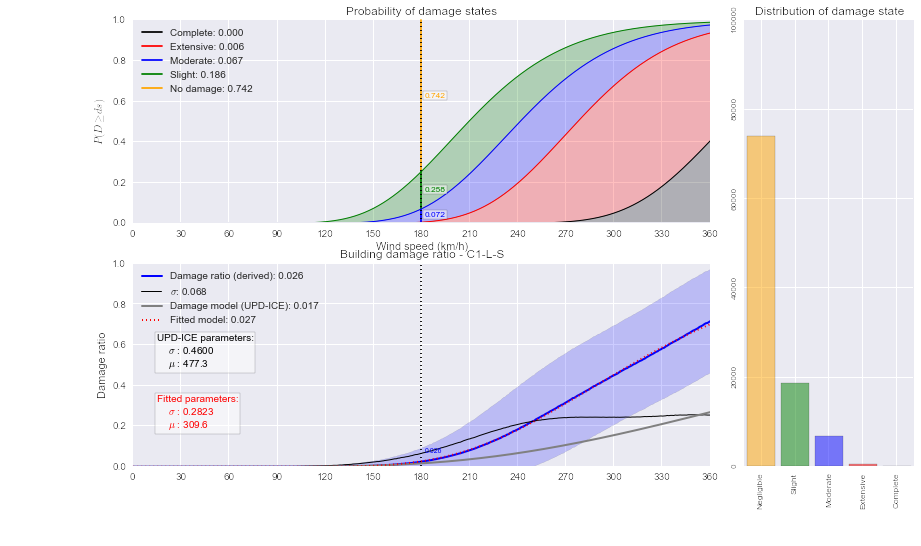

In [52]:
seed = 10574

# Drop down menu to select the building type:
bldselect = widgets.Dropdown(options=bldtypes, value=bldtypes[0],
                             description="Building type")

# Slider widget to set the wind speed:
windselect = widgets.FloatSlider(min=0.0, max=360., step=1., value=180., 
                                 description="Wind speed (km/h)" )

w = interactive(plotcurve, 
                buildingtype=bldselect, 
                windspeed=windselect, 
                dmgindex=fixed(di),
                seed=fixed(seed))
display(w)

Now we cycle through all available building types and fit a lognormal cdf to the derived damage curve. These can then be mapped to the corresponding building types in the full (>100) suite of building type & height combinations used in GMMA RAP to evaluate impacts to the built environment. The shape parameter should correspond to the 'sd' field in the suite of curves, and the scale corresponds to the 'mean' field.

In [40]:
x = np.arange(0, 361., 1.)    
newcurves = dict()
print "Building type: shape  : scale  : UPD-ICE shape : UPD-ICE scale"
print "-------------------------------------------------------------- "
for bldtype in bldtypes:

    bldcurves = curves[bldtype]
    vcdf = bldcurves['vscale'] * lognorm.cdf(x, bldcurves['vshape'], 
                                              scale=bldcurves['vloc'])
    dmg_mean, dmg_sd = damage(bldcurves, x, di)
    xx = np.where(dmg_mean<=0.5)[0][-1]
    loc = x[xx]
    p = minimise(dmg_mean, bldcurves['vshape'], loc)
    print "{0:<13s}: {1:.5f}: {2:<7.2f}: {3:14.2f}: {4:<10.2f}".format(bldtype, p[0], p[1], 
                                                                       bldcurves['vshape'], bldcurves['vloc'])
    newcurves[bldtype] = {'vshape':p[0], 'vloc':p[1]}


Building type: shape  : scale  : UPD-ICE shape : UPD-ICE scale
-------------------------------------------------------------- 
C1-L-S       : 0.28267: 309.57 :           0.46: 477.26    
C1-L-W       : 0.23569: 254.17 :           0.52: 416.41    
C1-M         : 0.27348: 227.53 :           0.33: 221.00    
CHB-L-S      : 0.23495: 298.85 :           0.44: 469.00    
CHB-L-W      : 0.33052: 256.84 :           0.59: 455.00    
CWS-L-S      : 0.19082: 374.20 :           0.16: 398.00    
CWS-L-W      : 0.35890: 221.74 :           0.52: 321.00    
MWS-L-S      : 0.19070: 374.15 :           0.16: 398.00    
MWS-L-W      : 0.35882: 221.67 :           0.52: 321.00    
N-L          : 0.36337: 171.95 :           0.20: 136.00    
S1-L         : 0.50463: 235.06 :           0.61: 379.10    
S1-M         : 0.22078: 186.34 :           0.24: 180.00    
S3-L         : 0.33249: 349.01 :           0.37: 387.00    
W1-L         : 0.33040: 211.24 :           0.09: 176.00    
W3-L         : 0.42830: 130.68 : 

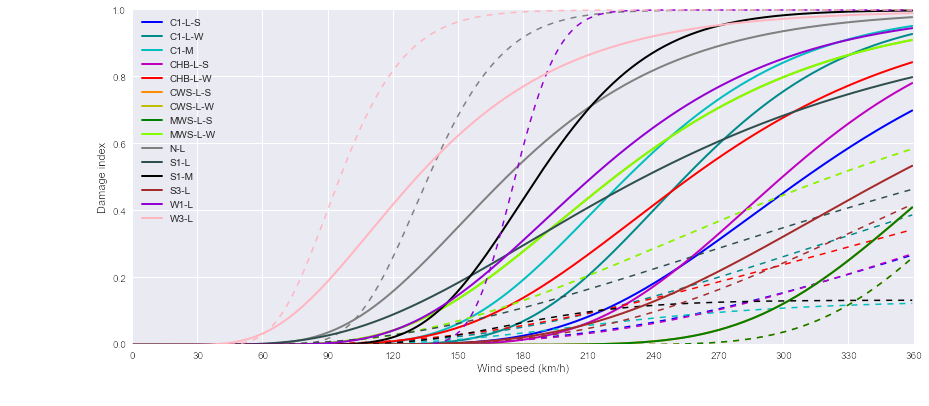

In [16]:
fig, ax = plt.subplots(1,1, figsize=(14,6))
x = np.arange(0, 360., 1.)
colors=['b', 'darkcyan', 'c', 'm',  'r', 
        'darkorange', 'y', 'g', 'chartreuse', '0.5',
        'darkslategray', 'k', 'brown',  'darkviolet', 'lightpink']

for c, bldtype in zip(colors, bldtypes):
    bldcurves = curves[bldtype]
    ncurves = newcurves[bldtype]
    vcdf = bldcurves['vscale'] * lognorm.cdf(x, bldcurves['vshape'], scale=bldcurves['vloc'])
    ncdf = lognorm.cdf(x, ncurves['vshape'], scale=ncurves['vloc'])
    ax.plot(x, ncdf, linewidth=2, color=c, label=bldtype)
    ax.plot(x, vcdf, linewidth=1.5, color=c, linestyle='--')

l = ax.legend(loc=2)
for t in l.get_texts():
    t.set_fontsize('medium')
    
ax.set_xlim((0,360))
ax.set_xticks(np.arange(0, 361., 30))
ax.set_ylim((0,1))
ax.set_ylabel("Damage index")
ax.set_xlabel("Wind speed (km/h)")